[Reference](https://ai.plainenglish.io/recurrent-neural-networks-explained-simply-47e21bc5f949)

In [1]:
import yfinance as yf
from datetime import datetime, timedelta

symbol = "NVDA"

end_date = datetime.now()
start_date = end_date - timedelta(days=1000)
# Fetch stock data using yfinance
stock = yf.Ticker(symbol)
data = stock.history(start=start_date, end=end_date)

data.shape

(685, 7)

In [2]:
# 2. Preprocess Data
from sklearn.preprocessing import MinMaxScaler

close_data = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

In [3]:
# Create training sequences
import numpy as np
# Create a training and test split
training_data_len = int(np.ceil(len(close_data) * 0.9))

# Create the training data set
train_data = scaled_data[0:int(training_data_len), :]
X_train = []
y_train = []
sequence_length = 60

for i in range(sequence_length, len(train_data)):
    X_train.append(train_data[i-sequence_length:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(f"Training data shapes: {X_train.shape}, {y_train.shape}")

# Create the testing data set
test_data = scaled_data[training_data_len - sequence_length:, :]
X_test = []
y_test = close_data[training_data_len:, :] # Actual values

for i in range(sequence_length, len(test_data)):
    X_test.append(test_data[i-sequence_length:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

print(f"Testing data shapes: {np.array(X_test).shape}, {np.array(y_test).shape}")

Training data shapes: (557, 60, 1), (557,)
Testing data shapes: (68, 60, 1), (68, 1)


In [4]:
# 3. Build the Simple RNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 60, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 60, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,751 (49.81 KB)

 Trainable params: 12,751 (49.81 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# 4. Train the Model
print("\n--- Training Model ---")
model.fit(X_train, y_train, epochs=3, batch_size=32)
print("--- Training Complete ---\n")


--- Training Model ---
Epoch 1/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 0.7213
Epoch 2/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.2310
Epoch 3/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.2056
--- Training Complete ---



In [6]:
# Get the models predicted price values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions) # Un-scale the values

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step
Root Mean Squared Error (RMSE): $7.43


/tmp/ipython-input-2601611839.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


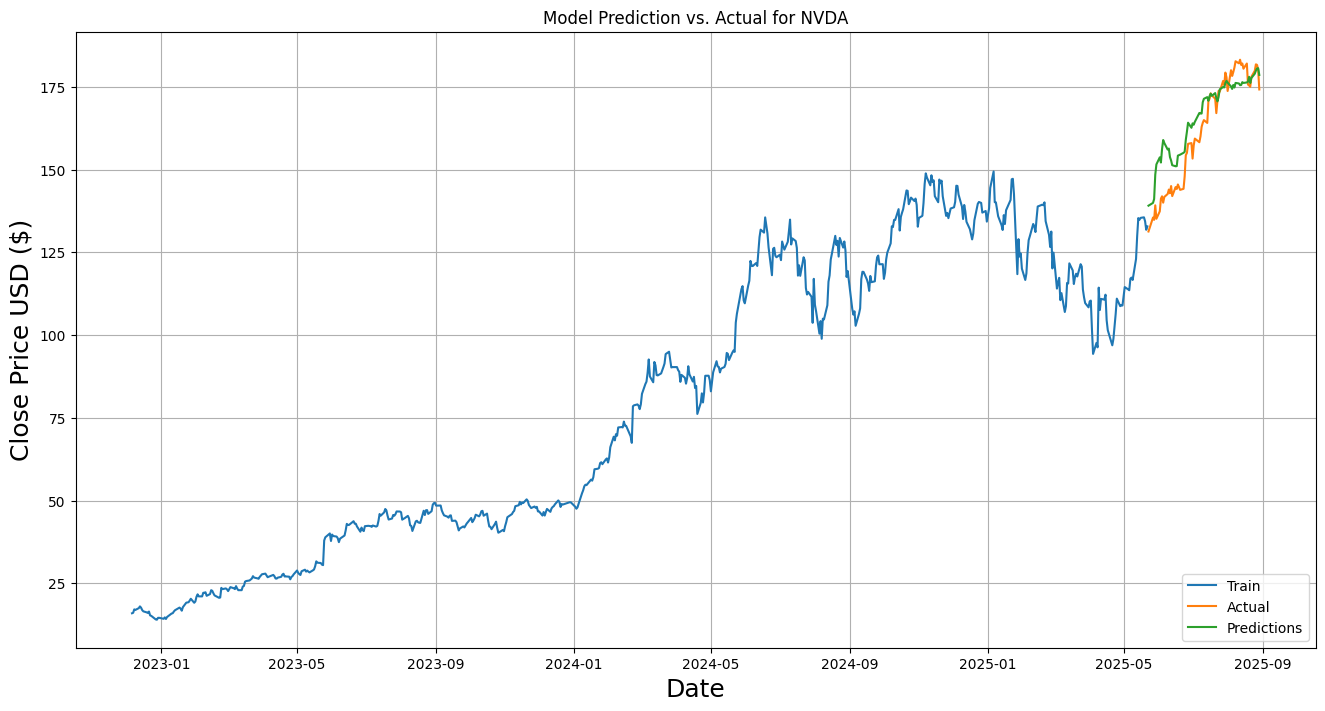

In [7]:
import matplotlib.pyplot as plt

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title(f'Model Prediction vs. Actual for {symbol}')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.grid(True)
plt.show()